# Create Ground Truth

In [1]:
import pyro
import pyro.distributions as dist
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd
import numpy as np
import torch

from datetime import date

/Users/zainkhan/miniconda3/envs/comp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def GroundTruthModel(gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)
    
    lambda1 = torch.tensor(0.2)
    lambda2 = torch.tensor(-0.1)
    lambda3 = torch.tensor(-0.8)
    lambda4 = torch.tensor(0.8)

    lambda5 = torch.tensor(0.8)
    lambda6 = torch.tensor(0.1)
    lambda7 = torch.tensor(-0.8)
    lambda8 = torch.tensor(0.2)
    
    u1 = pyro.sample("u1", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u2 = pyro.sample("u2", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u3 = pyro.sample("u3", dist.Normal(torch.tensor(0.), torch.tensor(0.8)))
    u4 = pyro.sample("u4", dist.Normal(torch.tensor(0.), torch.tensor(1.)))
    
    a_prob = torch.sigmoid(gamma_shift * lambda1 * C + u1)
    a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob))
    a = pyro.sample("A", dist.Delta(a_val))
    
    r_val = pyro.sample("r", dist.Normal(0., 1.)) + lambda2 * a_val + u2 
    r = pyro.sample("R", dist.Delta(r_val))
    
    y_prob = torch.sigmoid(lambda3 * a_val + lambda4 * r_val + u3)
    y_val = pyro.sample("y", dist.Bernoulli(y_prob))
    y = pyro.sample("Y", dist.Delta(y_val))
    
    t_val = pyro.sample("t", dist.Normal(lambda5 * y_val + lambda6 * r_val + lambda7 * a_val + u4, 1. + gamma_shift * lambda8 * C))
    t = pyro.sample("T", dist.Delta(t_val))

In [3]:
trace_handler = pyro.poutine.trace(GroundTruthModel)
samples = pd.DataFrame(columns=['A', 'R', 'T', 'Y'])
sample_noise = pd.DataFrame(columns=['u1', 'u2', 'u3', 'u4'])

In [4]:
num_samples = 2000
all_samples=[]

for i in range(num_samples):
    trace = trace_handler.get_trace()
    a = trace.nodes['A']['value'].numpy().item()
    r = trace.nodes['R']['value'].numpy().item()
    t = trace.nodes['T']['value'].numpy().item()
    y = trace.nodes['Y']['value'].numpy().item()
    sample = pd.DataFrame([[a, r, t, y]], columns=['A', 'R', 'T', 'Y'])
    
    u1 = trace.nodes['u1']['value'].numpy().item()
    u2 = trace.nodes['u2']['value'].numpy().item()
    u3 = trace.nodes['u3']['value'].numpy().item()
    u4 = trace.nodes['u4']['value'].numpy().item()
    noise = pd.DataFrame([[u1, u2, u3, u4]], columns=['u1', 'u2', 'u3', 'u4'])

    samples = pd.concat([samples, sample], ignore_index=True)
    sample_noise = pd.concat([sample_noise, noise], ignore_index=True)

samples

,A,R,T,Y
0,0.0,1.451493,-0.530997,0.0
1,1.0,-1.895861,-0.66953,0.0
2,0.0,0.961535,0.204991,0.0
3,1.0,-1.269897,-2.686329,0.0
4,0.0,-0.735994,-0.232907,0.0
...,...,...,...,...
1995,1.0,-2.271236,-2.140921,0.0
1996,0.0,-1.57434,-1.151274,0.0
1997,0.0,0.71968,-0.446798,0.0
1998,1.0,0.531097,1.016322,0.0


In [7]:
date_time = date.today().strftime('%m-%d-%Y')
samples.to_csv(f'../data/{date_time}-src-groundtruth.csv', index=False)
sample_noise.to_csv(f'../data/{date_time}-src-groundtruth-noise.csv', index=False)

#samples = pd.read_csv(f'../data/{date_time}-src-groundtruth.csv')
#samples.head()

<AxesSubplot:>

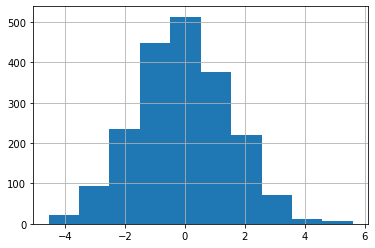

In [24]:
samples['T'].hist()

In [20]:
samples.head()

,A,R,T,Y
0,0.0,1.451493,-0.530997,0.0
1,1.0,-1.895861,-0.66953,0.0
2,0.0,0.961535,0.204991,0.0
3,1.0,-1.269897,-2.686329,0.0
4,0.0,-0.735994,-0.232907,0.0


# Learn Parameters from Ground Truth

In [33]:
def ProposedModel(a=None, r=None, t=None, y=None, gamma_shift=0., C=0.):
    gamma_shift = torch.tensor(gamma_shift)
    C = torch.tensor(C)

    lambda1 = pyro.sample("lambda1", dist.Normal(0., 1.))
    lambda2 = pyro.sample("lambda2", dist.Normal(0., 1.))
    lambda3 = pyro.sample("lambda3", dist.Normal(0., 1.))
    lambda4 = pyro.sample("lambda4", dist.Normal(0., 1.))
    lambda5 = pyro.sample("lambda5", dist.Normal(0., 1.))
    lambda6 = pyro.sample("lambda6", dist.Normal(0., 1.))
    lambda7 = pyro.sample("lambda7", dist.Normal(0., 1.))
    lambda8 = pyro.sample("lambda8", dist.Normal(0., 1.))
    
    with pyro.plate("data", a.size(0)):
        u1 = pyro.sample("u1", dist.Normal(0., 0.6))
        u2 = pyro.sample("u2", dist.Normal(0., 0.8))
        u3 = pyro.sample("u3", dist.Normal(0., 0.9))
        u4 = pyro.sample("u4", dist.Normal(0., 1.2))
        
        a_prob = torch.sigmoid(gamma_shift*lambda1*C + u1)
        a_val = pyro.sample("a", dist.Bernoulli(probs=a_prob), obs=a)

        r_val = pyro.sample("r", dist.Normal(lambda2*a_val + u2, 1.), obs=r) 

        y_prob = torch.sigmoid(lambda3*a_val + lambda4*r_val + u3)
        y_val = pyro.sample("y", dist.Bernoulli(probs=y_prob), obs=y)

        t_val = pyro.sample("t", dist.Normal(lambda5*y_val + lambda6*r_val + lambda7*a_val + u4, 
                                             1. + gamma_shift*lambda8*C), obs=t)
        
        return a_val, r_val, y_val, t_val

In [34]:
from pyro.infer.autoguide import AutoDelta, AutoNormal

autodelta = AutoDelta(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))
autonormal = AutoNormal(pyro.poutine.block(ProposedModel, hide=["u1", "u2", "u3", "u4"]))

In [35]:
def train(data, num_steps, num_obs, model, guide):
    data = torch.tensor(data.astype(float).values)
    
    pyro.clear_param_store()
    loss_func = pyro.infer.Trace_ELBO()
    svi = pyro.infer.SVI(model, guide, pyro.optim.Adam({"lr": 0.01}), loss=loss_func)
    
    losses = []
    for i in tqdm(range(num_steps)):
        loss = svi.step(data[:, 0], data[:, 1], data[:, 2], data[:, 3])
        losses.append(loss)
        
    plt.figure()
    plt.plot(losses)
    plt.show()
    
    posterior_params = {k: np.array(v.data) for k, v in pyro.get_param_store().items()}
    return posterior_params

  0%|                                                                            | 0/1000 [00:00<?, ?it/s]/Users/zainkhan/miniconda3/envs/comp/lib/python3.8/site-packages/pyro/util.py:303: UserWarning: Found vars in model but not guide: {'u3', 'u1', 'u2', 'u4'}
  warnings.warn(f"Found vars in model but not guide: {bad_sites}")
100%|████████████████████████████████████████████████████████████████| 1000/1000 [00:02<00:00, 413.54it/s]


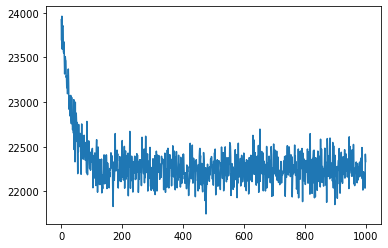

In [36]:
learned_params = train(samples, num_steps=1000, num_obs=2000, model=ProposedModel, guide=autodelta)

In [37]:
learned_params

{'AutoDelta.lambda1': array(-6.685841e-24, dtype=float32),
 'AutoDelta.lambda2': array(-0.16836806, dtype=float32),
 'AutoDelta.lambda3': array(-0.760402, dtype=float32),
 'AutoDelta.lambda4': array(0.733341, dtype=float32),
 'AutoDelta.lambda5': array(0.8162695, dtype=float32),
 'AutoDelta.lambda6': array(0.09432353, dtype=float32),
 'AutoDelta.lambda7': array(-0.7792699, dtype=float32),
 'AutoDelta.lambda8': array(-1.207507e-24, dtype=float32)}

In [38]:
for i in range(1, 9):
    learned_params[f'lambda{i}'] = learned_params.pop(f'AutoDelta.lambda{i}')
    learned_params[f'lambda{i}'] = float(learned_params[f'lambda{i}'])
learned_params

{'lambda1': -6.685840718628694e-24,
 'lambda2': -0.16836805641651154,
 'lambda3': -0.7604020237922668,
 'lambda4': 0.7333409786224365,
 'lambda5': 0.8162695169448853,
 'lambda6': 0.09432353079319,
 'lambda7': -0.7792698740959167,
 'lambda8': -1.2075070210390871e-24}

# Twin-World Counterfactuals 

1. Abduction: Predict the ‘state of the world’ (the exogenous noise, e) that is compatible with
the observations, x, i.e. infer PG(e|x).

2. Action: Perform an intervention corresponding to the desired manipulation, resulting in a modified SCM Ge = Gx;do(xek) = (Se, PG(e|x)).
    
3. Prediction: Compute the quantity of interest based on the distribution entailed by the counterfactual SCM, PG(x).

In [152]:
samples.iloc[1], sample_noise.iloc[2]

(A    0.000000
 R    0.873463
 T    3.079657
 Y    1.000000
 Name: 1, dtype: float64,
 u1    0.739980
 u2    0.116692
 u3    1.111096
 u4    0.080837
 Name: 2, dtype: float64)

In [40]:
def infer_exogenous(obs, model):
    input_a = torch.tensor(np.array([obs['a']]))
    input_r = torch.tensor(np.array([obs['r']]))
    input_y = torch.tensor(np.array([obs['y']]))
    input_t = torch.tensor(np.array([obs['t']]))
    
    cond_sample = pyro.condition(lambda: model(input_a, input_r, input_t, input_y), obs)
    cond_trace = pyro.poutine.trace(cond_sample).get_trace()
    
    exogenous = {k: cond_trace.nodes[k]['value'] for k in  ['u1', 'u2', 'u3', 'u4']}
    return exogenous


def counterfactual(model, obs, learned_params):
    # Infer state of world (ie learn noise)
    exogenous = infer_exogenous(obs, model)
    exogenous_and_learned = {**exogenous, **learned_params}
    
    # Find counterfactual A value (a') for this sample
    input_a = torch.tensor(np.array([obs['a']]))
    cf_a = 0 if input_a.numpy()[0] == 1. else 1.
    
    # Compute counterfactual sample
    cf_model = pyro.do(pyro.condition(model, data=exogenous_and_learned), data={'a': torch.tensor(cf_a)})
    
    return cf_model, cf_a

In [41]:
# Get sample
obs = {k.lower(): torch.tensor(samples.iloc[0][k]) for k in ['A', 'R', 'Y', 'T']} 

# Infer noise/state of the world and produce counterfactual
cf, cf_a = counterfactual(ProposedModel, obs, learned_params)

input_a = torch.tensor(np.array([obs['a']]))
print(cf(input_a))

(tensor(1.), tensor([-1.4316]), tensor([0.]), tensor([0.2857]))


In [42]:
obs

{'a': tensor(0., dtype=torch.float64),
 'r': tensor(1.4515),
 'y': tensor(0.),
 't': tensor(-0.5310)}